In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

## Q4: linear quadrilateral element

The Q4 element is obtained by tensor product of the linear element in 1D. It has four nodes and four shape functions in the parent domain. The points in the parent domain $\mathbf{\xi}=[\xi,\eta]$ are 

$[-1,-1], [1,-1], [1,1], [-1,1]$ 

The shape functions are 

$N_1(\xi,\eta)=\frac{1}{4}(1-\xi)(1-\eta)$

$N_2(\xi,\eta)=\frac{1}{4}(1+\xi)(1-\eta)$

$N_3(\xi,\eta)=\frac{1}{4}(1+\xi)(1+\eta)$

$N_4(\xi,\eta)=\frac{1}{4}(1-\xi)(1+\eta)$

Below you can see how to use this element to calculate interpolations and gradients of scalar and vector fields

In [2]:
# Definition of the shape function and the derivative with respect to parent domain xi

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

In [3]:
# read in a mesh 
## Read in a mesh 
meshfile = open("ring_mesh_ordered.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,4),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
    elements[i,3] = int(aux[3])
#print(node_X)
#print(elements)
print(n_node)
print(n_elem)

576
512


In [5]:
# Create some analytical field and evaluate it at the nodes, we can have a scalar and a vector field 
def theta(x,y):
    return x**2+y**2

def dthetadx(x,y):
    return np.array([2*x,2*y])

def uvec(x,y):
    return np.array([x,y])

def gradx_u(x,y):
    return np.array([[1,0],[0,1]])

In [6]:
# evaluate theta and uvec at the nodes
theta_nodes = np.zeros((n_node))
u_nodes = np.zeros((n_node,2))
for i in range(n_node):
    theta_nodes[i] = theta(node_X[i,0],node_X[i,1])
    u_nodes[i] = uvec(node_X[i,0],node_X[i,1])

In [22]:
# use finite element discretization to interpolate the fields theta, uvec at the center of the element
# also use the discretization to calculate the gradient at the center of the element 
# since we have the analytical field, also evaluate the analytical field for comparison 
theta_elem = np.zeros((n_elem))
u_elem = np.zeros((n_elem,2))
gradx_theta_elem = np.zeros((n_elem,2))
gradx_u_elem = np.zeros((n_elem,2,2))
theta_elem_h = np.zeros((n_elem))
u_elem_h = np.zeros((n_elem,2))
gradx_theta_elem_h = np.zeros((n_elem,2))
gradx_u_elem_h = np.zeros((n_elem,2,2))


for i in range(n_elem):
    
    # read out the nodes that make up this element 
    node1 = elements[i,0]
    node2 = elements[i,1]
    node3 = elements[i,2]
    node4 = elements[i,3]
    # Get the coordinates of the quad
    x1 = node_X[node1] # note these are vectors with x and y coords 
    x2 = node_X[node2]
    x3 = node_X[node3]
    x4 = node_X[node4]
    
    # picking a point in parent domain, let's do the center!  
    xi = 0.0 
    eta = 0.0
    
    # evaluate the isoparametric map 
    Ns = Nvec(xi,eta)
    x = Ns[0]*x1 + Ns[1]*x2 + Ns[2]*x3 + Ns[3]*x4 # note this outputs a vector with x and y coordinates 
    
    # evaluate the Jacobian 
    dNsdxi = dNvecdxi(xi,eta)
    dxdxi = np.outer(x1,dNsdxi[:,0])+np.outer(x2,dNsdxi[:,1])+np.outer(x3,dNsdxi[:,2])+np.outer(x4,dNsdxi[:,3])
    
    # get gradient of basis function with respect to x using inverse jacobian 
    JinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(JinvT,dNsdxi)
    
    # now time to do the interpolation of the fields theta and u, and their gradients 
    # first for theta 
    theta1 = theta_nodes[node1]
    theta2 = theta_nodes[node2]
    theta3 = theta_nodes[node3]
    theta4 = theta_nodes[node4]
    # interpolate using node values and shape functions at xi=0, eta=0
    theta_at_center_h = Ns[0]*theta1 + Ns[1]*theta2 + Ns[2]*theta3 + Ns[3]*theta4 
    # get the gradient with respect to x at the center as well 
    gradx_theta_at_center_h = theta1*dNsdx[:,0] + theta2*dNsdx[:,1] + theta3*dNsdx[:,2] + theta4*dNsdx[:,3]
    # for comparison, the true solution is 
    theta_at_center = theta(x[0],x[1])
    gradx_theta_at_center = dthetadx(x[0],x[1])
    
    # do the same for u 
    u1 = u_nodes[node1]
    u2 = u_nodes[node2]
    u3 = u_nodes[node3]
    u4 = u_nodes[node4]
    # interpolate using node values and shape functions at xi=0, eta=0
    u_at_center_h = Ns[0]*u1 + Ns[1]*u2 + Ns[2]*u3 + Ns[3]*u4 
    # get the gradient with respect to x at the center as well 
    gradx_u_at_center_h = np.outer(u1,dNsdx[:,0]) + np.outer(u2,dNsdx[:,1]) + np.outer(u3,dNsdx[:,2]) + np.outer(u4,dNsdx[:,3])
    # for comparison, the true solution is 
    u_at_center = uvec(x[0],x[1])
    gradx_u_at_center = gradx_u(x[0],x[1])
    
    # store 
    theta_elem[i] = theta_at_center
    u_elem[i] = u_at_center
    gradx_theta_elem[i] = gradx_theta_at_center
    gradx_u_elem[i] = gradx_u_at_center
    theta_elem_h[i] = theta_at_center_h
    u_elem_h[i] = u_at_center_h
    gradx_theta_elem_h[i] = gradx_theta_at_center_h
    gradx_u_elem_h[i] = gradx_u_at_center_h


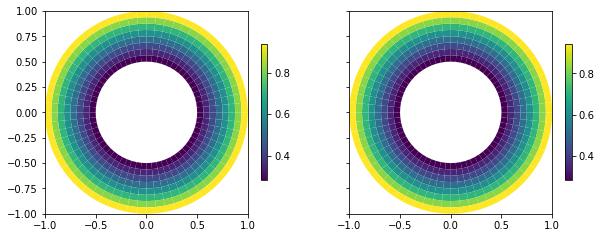

In [29]:
## PLOT THETA 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,5))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = theta_elem[i]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = theta_elem_h[i]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)

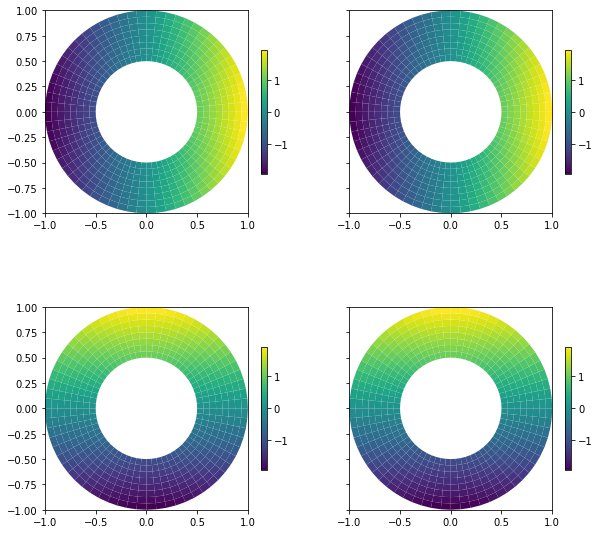

In [28]:
## PLOT gradx_THETA 
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(10,10))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_aspect('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_aspect('equal')

patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = gradx_theta_elem[i,0]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = gradx_theta_elem_h[i,0]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)

patches3 = []
colors3 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches3.append(polygon)
    colors3[i] = gradx_theta_elem[i,1]
p3 = PatchCollection(patches3)
p3.set_array(colors3)
ax3.add_collection(p3)

patches4 = []
colors4 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches4.append(polygon)
    colors4[i] = gradx_theta_elem_h[i,1]
p4 = PatchCollection(patches4)
p4.set_array(colors4)
ax4.add_collection(p4)

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)
plt.colorbar(p4,ax=ax4,shrink=0.5)

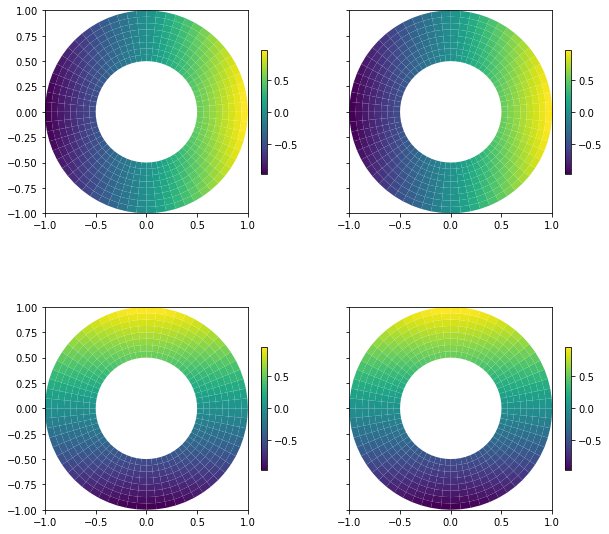

In [27]:
## PLOT U 
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(10,10))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_aspect('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_aspect('equal')

patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = u_elem[i,0]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = u_elem_h[i,0]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)

patches3 = []
colors3 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches3.append(polygon)
    colors3[i] = u_elem[i,1]
p3 = PatchCollection(patches3)
p3.set_array(colors3)
ax3.add_collection(p3)

patches4 = []
colors4 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches4.append(polygon)
    colors4[i] = u_elem_h[i,1]
p4 = PatchCollection(patches4)
p4.set_array(colors4)
ax4.add_collection(p4)

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)
plt.colorbar(p4,ax=ax4,shrink=0.5)

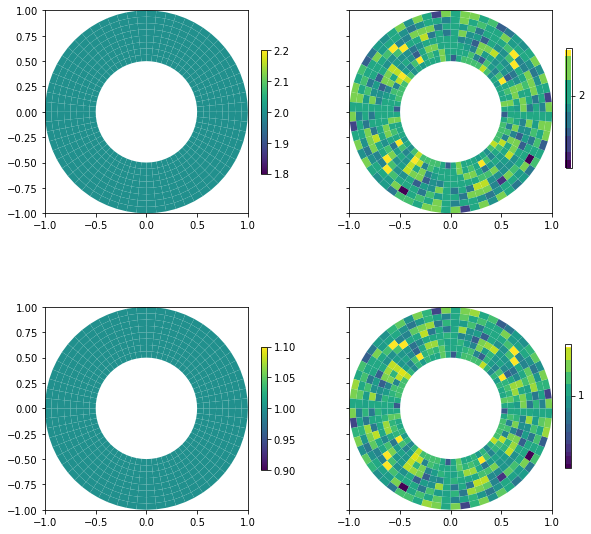

In [26]:
## PLOT the trace and determinant of gradx_u because I dont want to plot too many things 

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(10,10))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_aspect('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_aspect('equal')

patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = gradx_u_elem[i,0,0]+gradx_u_elem[i,1,1]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = gradx_u_elem_h[i,0,0]+gradx_u_elem_h[i,1,1]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)

patches3 = []
colors3 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches3.append(polygon)
    colors3[i] = gradx_u_elem[i,0,0]*gradx_u_elem[i,1,1] - gradx_u_elem[i,0,1]*gradx_u_elem[i,1,0]
p3 = PatchCollection(patches3)
p3.set_array(colors3)
ax3.add_collection(p3)

patches4 = []
colors4 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches4.append(polygon)
    colors4[i] = gradx_u_elem_h[i,0,0]*gradx_u_elem_h[i,1,1] - gradx_u_elem_h[i,0,1]*gradx_u_elem_h[i,1,0]
p4 = PatchCollection(patches4)
p4.set_array(colors4)
ax4.add_collection(p4)

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)
plt.colorbar(p4,ax=ax4,shrink=0.5)